In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

## Evaluating a simple function

Our aim is to evaluate the cosine function at many points:

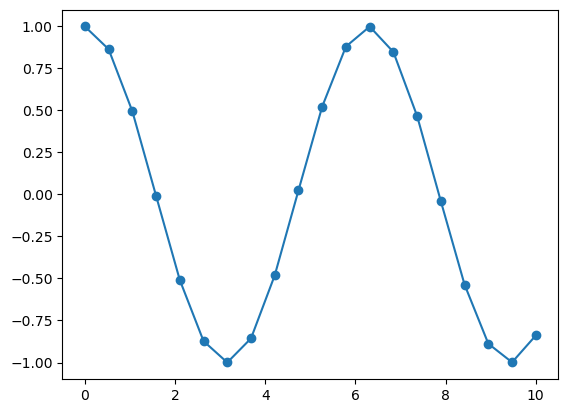

In [2]:
fig, ax = plt.subplots()
x = np.linspace(0, 10, 20)
ax.plot(x, np.cos(x))
ax.scatter(x, np.cos(x))

Now let's try with a large array.

### With NumPy

In [3]:
n = 100_000_000
x = np.linspace(0, 10, n)

In [4]:
%time np.cos(x)

CPU times: user 765 ms, sys: 63.7 ms, total: 829 ms
Wall time: 828 ms


array([ 1.        ,  1.        ,  1.        , ..., -0.83907164,
       -0.83907158, -0.83907153])

### With JAX

In [5]:
x = jnp.linspace(0, 10, n)

In [6]:
%time jnp.cos(x).block_until_ready()

CPU times: user 39.5 ms, sys: 15.9 ms, total: 55.4 ms
Wall time: 82.2 ms


Array([ 1.       ,  1.       ,  1.       , ..., -0.8390716, -0.8390716,
       -0.8390716], dtype=float32)

In [7]:
%time jnp.cos(x).block_until_ready()

CPU times: user 999 µs, sys: 241 µs, total: 1.24 ms
Wall time: 1.61 ms


Array([ 1.       ,  1.       ,  1.       , ..., -0.8390716, -0.8390716,
       -0.8390716], dtype=float32)

### Changing size triggers recompilation

In [8]:
x = jnp.linspace(0, 10, n + 1)

In [9]:
%time jnp.exp(x).block_until_ready()

CPU times: user 43.2 ms, sys: 0 ns, total: 43.2 ms
Wall time: 66.8 ms


Array([1.0000000e+00, 1.0000001e+00, 1.0000002e+00, ..., 2.2026467e+04,
       2.2026467e+04, 2.2026467e+04], dtype=float32)

In [10]:
%time jnp.exp(x).block_until_ready()

CPU times: user 1.07 ms, sys: 0 ns, total: 1.07 ms
Wall time: 1.64 ms


Array([1.0000000e+00, 1.0000001e+00, 1.0000002e+00, ..., 2.2026467e+04,
       2.2026467e+04, 2.2026467e+04], dtype=float32)

## Evaluating a more complicated function

In [11]:
def f(x):
    y = np.cos(2 * x**2) + np.sqrt(np.abs(x)) + 2 * np.sin(x**4) - 0.1 * x**2
    return y

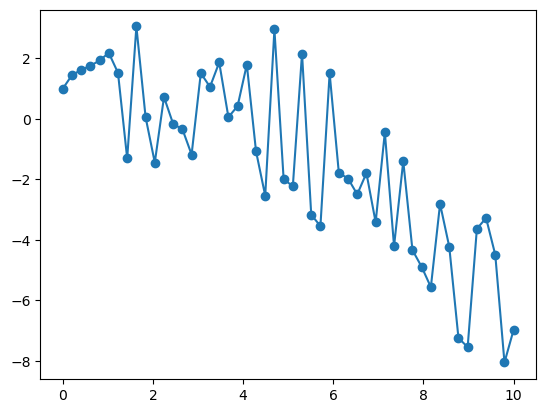

In [12]:
fig, ax = plt.subplots()
x = np.linspace(0, 10, 50)
ax.plot(x, f(x))
ax.scatter(x, f(x))

Now let's try with a large array.

### With NumPy

In [13]:
x = np.linspace(0, 10, n)

In [14]:
%time f(x)

CPU times: user 3.55 s, sys: 323 ms, total: 3.87 s
Wall time: 3.87 s


array([ 1.        ,  1.00031623,  1.00044721, ..., -6.96024642,
       -6.96100498, -6.96176344])

In [15]:
%time f(x)

CPU times: user 3.56 s, sys: 307 ms, total: 3.87 s
Wall time: 3.87 s


array([ 1.        ,  1.00031623,  1.00044721, ..., -6.96024642,
       -6.96100498, -6.96176344])

### With JAX

In [16]:
def f(x):
    y = jnp.cos(2 * x**2) + jnp.sqrt(jnp.abs(x)) + 2 * jnp.sin(x**4) - x**2
    return y

In [17]:
x = jnp.linspace(0, 10, n)

In [18]:
%time f(x).block_until_ready()

CPU times: user 225 ms, sys: 302 µs, total: 225 ms
Wall time: 424 ms


Array([  1.       ,   1.0003163,   1.0004472, ..., -96.96176  ,
       -96.96176  , -96.96176  ], dtype=float32)

In [19]:
%time f(x).block_until_ready()

CPU times: user 3.53 ms, sys: 563 µs, total: 4.1 ms
Wall time: 16.9 ms


Array([  1.       ,   1.0003163,   1.0004472, ..., -96.96176  ,
       -96.96176  , -96.96176  ], dtype=float32)

### Compiling the Whole Function

In [20]:
f = jax.jit(f)

In [21]:
%time f(x).block_until_ready()

CPU times: user 59.6 ms, sys: 3.92 ms, total: 63.6 ms
Wall time: 94 ms


Array([  1.       ,   1.0003163,   1.0004472, ..., -96.96176  ,
       -96.96176  , -96.96176  ], dtype=float32)

In [22]:
%time f(x).block_until_ready()

CPU times: user 979 µs, sys: 166 µs, total: 1.14 ms
Wall time: 1.58 ms


Array([  1.       ,   1.0003163,   1.0004472, ..., -96.96176  ,
       -96.96176  , -96.96176  ], dtype=float32)

## Solving Linear Systems

In [24]:
np.random.seed(1234)
n = 10_000
A = np.random.randn(n, n)
b = np.ones(n)

In [25]:
%time np.linalg.solve(A, b)

CPU times: user 17.7 s, sys: 298 ms, total: 18 s
Wall time: 2.3 s


array([-0.77949295, -0.10168624, -0.51875992, ..., -0.08049087,
        1.45538907, -0.3598163 ])

In [27]:
A, b = [jax.device_put(v) for v in (A, b)]

In [28]:
%time jnp.linalg.solve(A, b).block_until_ready()

CPU times: user 187 ms, sys: 97.2 ms, total: 284 ms
Wall time: 548 ms


Array([-0.7792064 , -0.10273829, -0.51833063, ..., -0.08171056,
        1.4558123 , -0.36051765], dtype=float32)

In [31]:
%time jnp.linalg.solve(A, b).block_until_ready()

CPU times: user 16.1 ms, sys: 4.01 ms, total: 20.1 ms
Wall time: 91.8 ms


Array([-0.7792064 , -0.10273829, -0.51833063, ..., -0.08171056,
        1.4558123 , -0.36051765], dtype=float32)